In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.metrics import (roc_auc_score, 
                             mean_squared_error, 
                             f1_score,
                             roc_curve,
                             auc,
                             accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV)
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

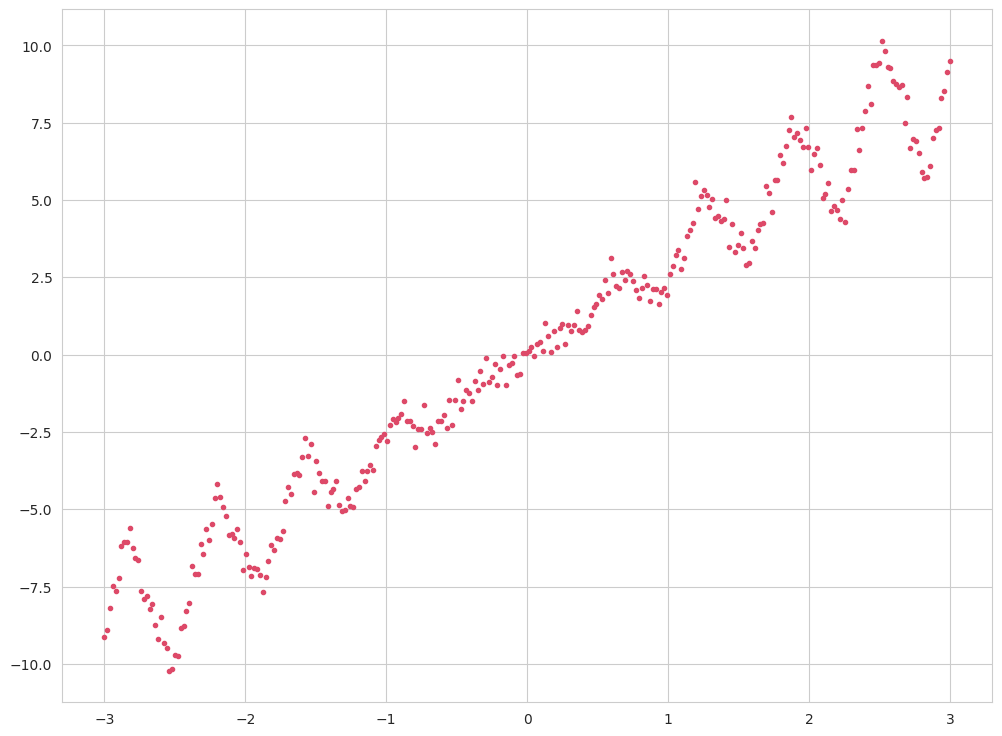

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать

np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.", c="#DD4968");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии

def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    plt.xlim([-3.2, 3.2])
    plt.ylim([-11, 11])

    plt.plot(x1, y_pred, linewidth=1.5, alpha=0.5)

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

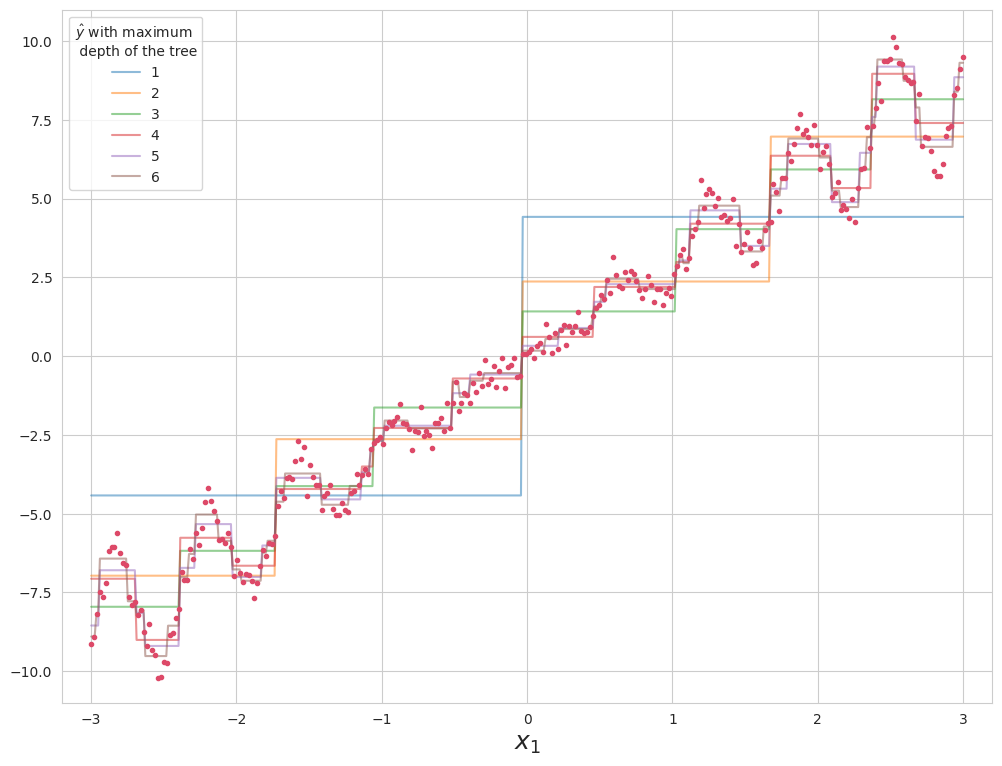

In [6]:
# Глубины от 1 до 6 выглядят откровенно так себе, посмотрим на них отдельно, убедимся в этом и не будем загромождать ими график:

legend = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
for depth in range(1, 7):
    tree_reg = DecisionTreeRegressor(max_depth=depth)
    tree_reg.fit(X_train, y_train)
    plot_regression_predictions(tree_reg, X, y)
    legend.append(depth)
plt.plot(X.reshape(-1), y.reshape(-1), "b.", c="#DD4968")
plt.legend(legend, title="$\hat{y}$ with maximum \n depth of the tree");

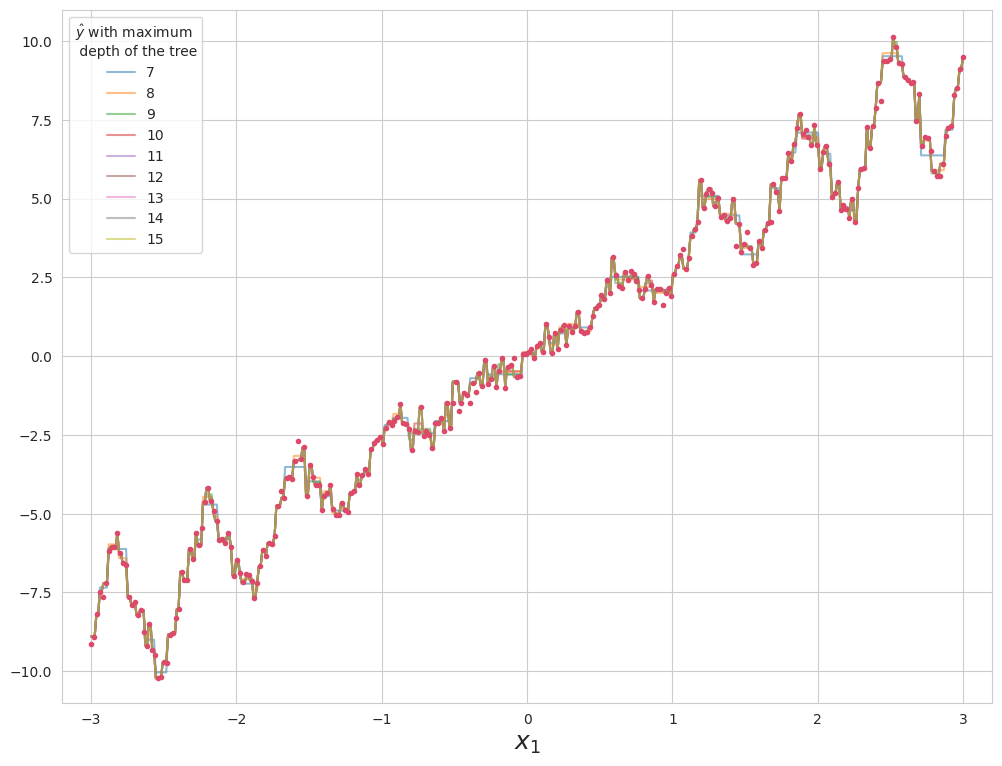

In [7]:
# Глубины от 7 до 15 выглядят лучше и после примерно 10 начинают сливаться, довольно хорошо предсказывая точки:

legend = []
for depth in range(7, 16):
    tree_reg = DecisionTreeRegressor(max_depth=depth)
    tree_reg.fit(X_train, y_train)
    plot_regression_predictions(tree_reg, X, y)
    legend.append(depth)
plt.plot(X.reshape(-1), y.reshape(-1), "b.", c="#DD4968")
plt.legend(legend, title="$\hat{y}$ with maximum \n depth of the tree");

А ниже показана немного странная попытка (но я попыталась!) изобразить графики bias и variance, но что-то, по-моему, пошло не так.  
Если верить этому графику, то глубина 5 уже норм, но если верить моим глазам, то я бы предпочла что-нибудь больше 10. Однако если настолько подробный и хорошо предсказывающий точки график как раз считается тем, у чего высокий variance, то да, можно взять что-то более общее, в районе тех самых 5. Во втором задании подобный диссонанс моего видения прекрасного с метриками тоже наблюдался. )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

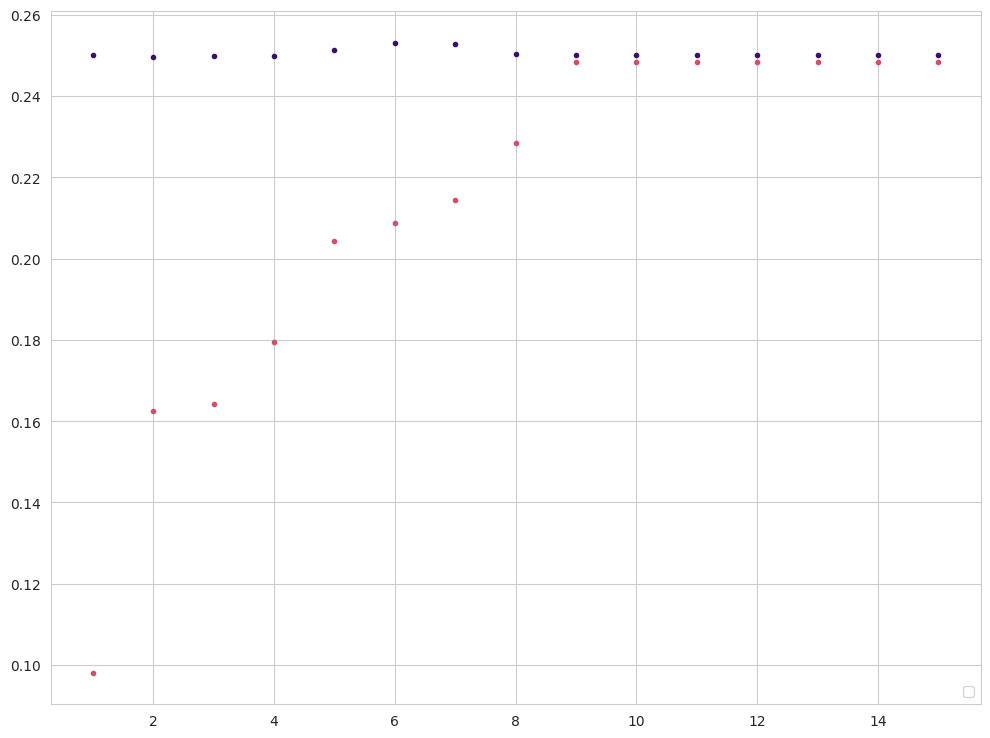

In [24]:
for depth in range(1, 16):
    tree_reg = DecisionTreeRegressor(max_depth=depth)
    tree_reg.fit(X_train, y_train)
    y_pred = tree_reg.predict(X_test)
    bias_sq = np.mean((y_test - np.mean(y_pred)) ** 2)
    variance = np.mean((y_pred - np.mean(y_pred)) ** 2)
    plt.plot(depth, bias_sq, "b.", c="#3B0F6F")
    plt.plot(depth, variance, "b.", c="#DD4968")

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезна следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [9]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

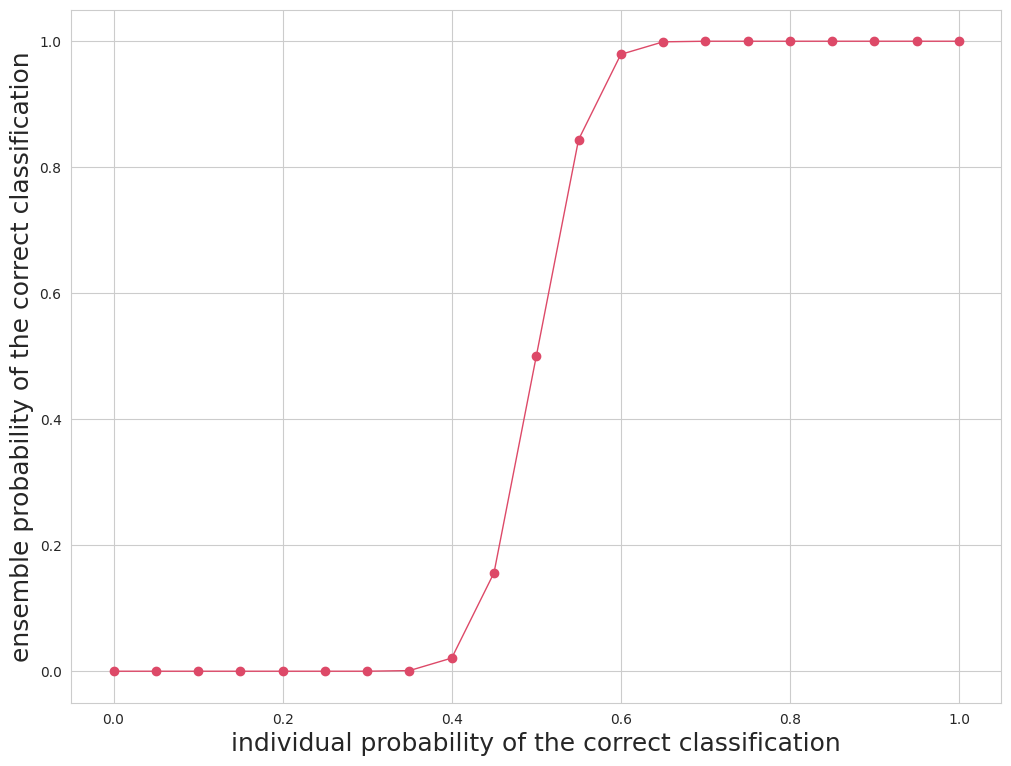

In [10]:
individual_pr = np.arange(0.0, 1.05, 0.05)
ensemble_pr = []
for p in individual_pr:
    m = np.sum([math.factorial(101) / ((math.factorial(101 - i) * math.factorial(i))) * p ** i * (1 - p) ** (101 - i) for i in range(51, 102)])
    ensemble_pr.append(m)
df = pd.DataFrame(data={"p": individual_pr, "m": ensemble_pr})
plt.plot(df.p, df.m, "o-", linewidth=1, c="#DD4968")
plt.xlabel("individual probability of the correct classification", fontsize=18)
plt.ylabel("ensemble probability of the correct classification", fontsize=18);

In [11]:
df

,p,m
0,0.00,0.000000e+00
1,0.05,7.190556e-39
2,0.10,1.152297e-24
3,0.15,6.796443e-17
4,0.20,8.422415e-12
5,0.25,3.258019e-08
6,0.30,1.294255e-05
7,0.35,9.872881e-04
8,0.40,2.089669e-02
9,0.45,1.562446e-01


А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [12]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

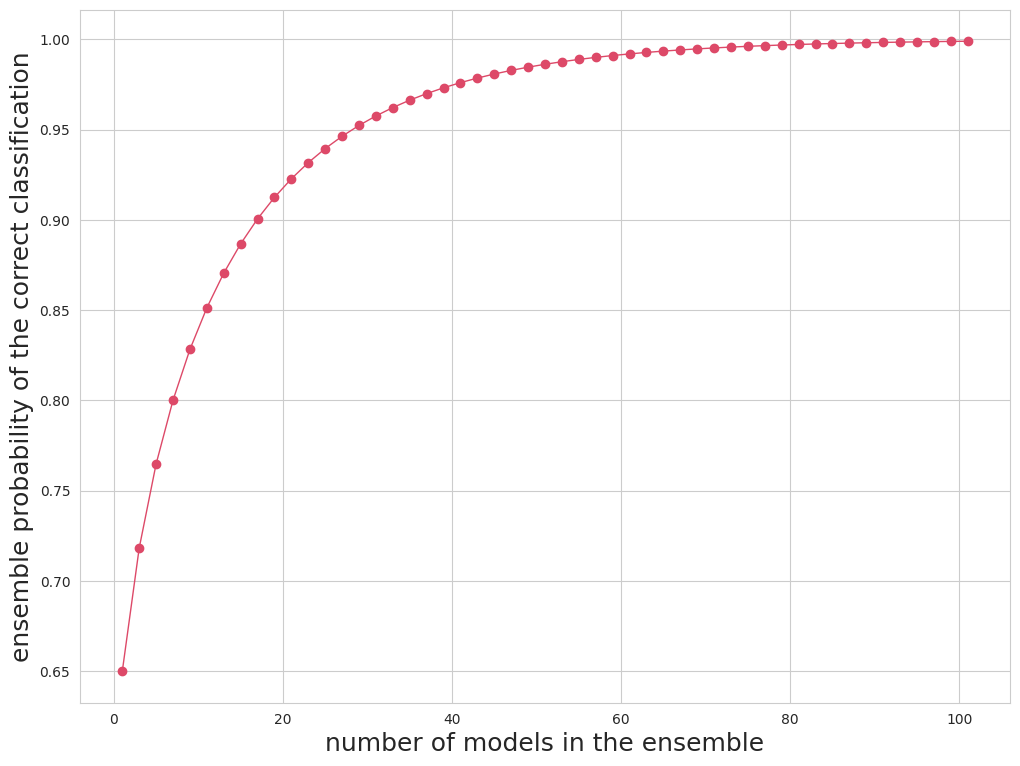

In [13]:
individual_pr = 0.65
number_of_models = np.arange(1, 102, 2)
ensemble_pr = []
for i in number_of_models:
    majority_vote = i // 2 + 1
    m = np.sum([math.factorial(i) / ((math.factorial(i - vote) * math.factorial(vote))) * 0.65 ** vote * 0.35 ** (i - vote) for vote in range(majority_vote, i + 1)])
    ensemble_pr.append(m)
df = pd.DataFrame(data={"i": number_of_models, "m": ensemble_pr})
plt.plot(df.i, df.m, "o-", linewidth=1, c="#DD4968")
plt.xlabel("number of models in the ensemble", fontsize=18)
plt.ylabel("ensemble probability of the correct classification", fontsize=18);

Опишите ваши наблюдения:

* Много классификаторов лучше, чем один, при строгом условии их независимости. График зависимости вероятности правильной классификации объекта от вероятности p (равной для всех моделей) правильно предсказать класс объекта имеет вид, приближённый к сигмоиде, и показывает, что начиная с p = 0.55 эффективность ансамбля резко подскакивает. Уже при p = 0.6 и 0.65 вероятность правильной классификации объекта будет равняться 0.9791033 и 0.9990127 соответственно. Далее скорость роста замедляется, но в итоге приходит к 1.0 при p = 1.0. Т.е. в ансамбле алгоритмы "исправляют" ошибки друг друга, что в сумме даёт лучший результат.
* В случае, если вероятность каждой модели в ансамбле правильно предсказывать класс объекта фиксирована и равна 0.65, то зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле описывается экспоненциальной функцией: с увеличением числа моделей увеличивается и вероятность, что подтверждает вывод о том, что использование ансамбля уменьшает ошибку каждой модели в отдельности, и что много классификаторов в заданных условиях (независимость) лучше, чем немного и тем более - один.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [14]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            feat_ids = np.random.choice(range(X.shape[1]), self.max_features, replace=False)
            samples = np.unique(np.random.choice(range(X.shape[0]), X.shape[0], replace=True))
            
            self.feat_ids_by_tree.append(feat_ids)
            
            clf = DecisionTreeClassifier(class_weight='balanced',
                                        max_depth=self.max_depth, 
                                        max_features=self.max_features, 
                                        random_state = self.random_state)

            clf.fit(X[samples, :][:, feat_ids], y[samples])
            self.trees.append(clf)
        return self
        
    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        predictions = []
        for i in range(self.n_estimators):
            feat_ids = self.feat_ids_by_tree[i]
            predictions.append(self.trees[i].predict_proba(X[:,feat_ids]))
        return np.mean(predictions, axis=0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [15]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha, c="#DD4968")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha, c="#000003")
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

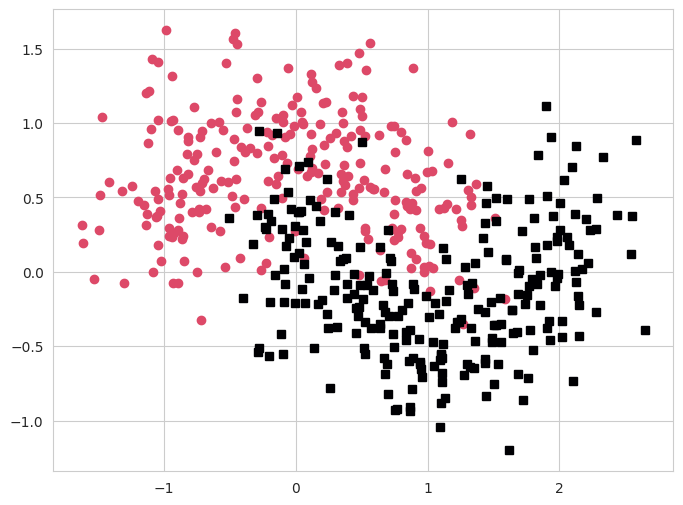

In [16]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", c="#DD4968")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", c="#000003")
plt.show()

In [17]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

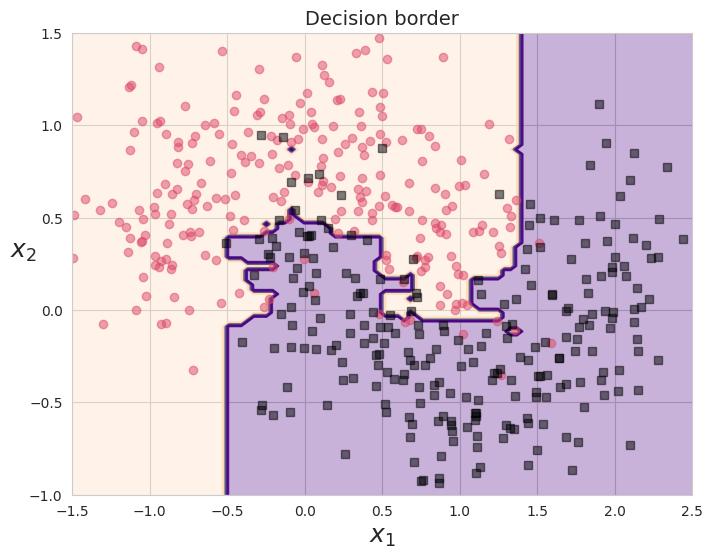

In [18]:
# Мне нравится, когда граница выглядит так:

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.1, random_state=SEED)

plt.figure(figsize=(8, 6))
clf = RandomForestClassifierCustom(n_estimators=18, max_depth=7, max_features=2, random_state=SEED)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

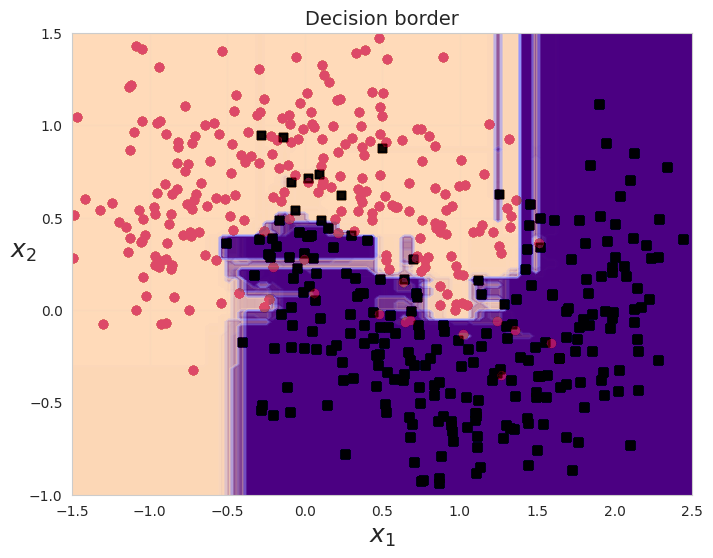

In [20]:
# 100 наложенных деревьев, построенных на разных выборках из X и y, поддерживают моё видение красивых границ. 
# Видим, что "хорошие области", соответствующие реальному разделению данных, являются общими между деревьями (тёмными), 
# а "плохие" - индивидуальны (светлые). Тёмная картинка выглядит в целом похожей на ту, которую я подобрала выше.

plt.figure(figsize=(8, 6))
for i in range(1, 101):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=i)
    clf = RandomForestClassifierCustom(max_depth=7, max_features=2, random_state=SEED)
    clf.fit(X_train, y_train)
    plot_decision_boundary(clf, X, y, alpha=0.02, contour=False)
plt.title("Decision border", fontsize=14)
plt.show()

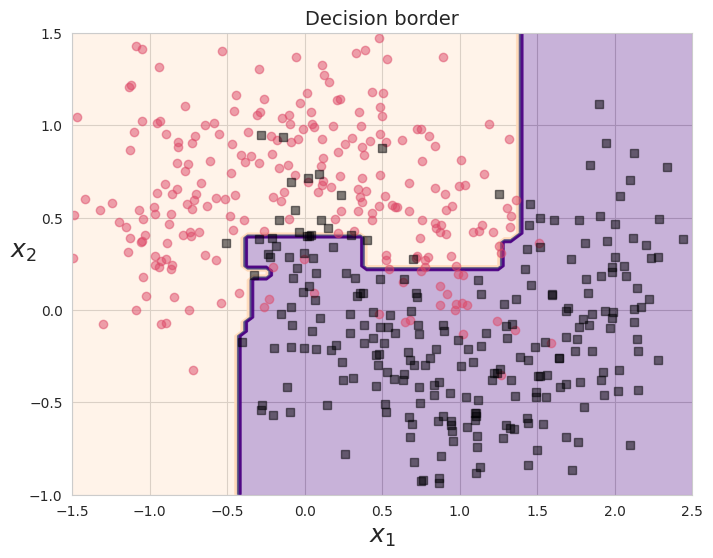

In [21]:
# Но roc-auc score считает иначе: его максимум (0.961 при max depth = 4 и estimators = 6) на визуализации выглядит более общим:
# (подбор этих параметров приведён на пару ячеек ниже)

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.1, random_state=SEED)

plt.figure(figsize=(8, 6))
clf = RandomForestClassifierCustom(n_estimators=6, max_depth=4, max_features=2, random_state=SEED)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.1, random_state=SEED)

best_parameters = {"max_depth": 0, "n_estimators": 0, "qual": 0}
for depth in range(1, 15):
    for estimators in range(1, 20):
        clf = RandomForestClassifierCustom(n_estimators=estimators, max_depth=depth, max_features=2, random_state=SEED)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        qual = roc_auc_score(y_true=y_test, y_score=y_pred_proba)
        if qual > best_parameters["qual"]:
            best_parameters["qual"] = qual
            best_parameters["max_depth"] = depth
            best_parameters["n_estimators"] = estimators
            
print(f"The best RandomForestClassifierCustom roc-auc score: \
{best_parameters['qual']:.03f} with max depth {best_parameters['max_depth']} and {best_parameters['n_estimators']} estimators.")

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [ ]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу

def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [ ]:
# Загрузим данные

breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

**EDA**

Для удобства сразу выпишем информацию о переменных:

* radius (mean of distances from center to points on the perimeter)

* texture (standard deviation of gray-scale values)

* perimeter

* area

* smoothness (local variation in radius lengths)

* compactness (perimeter^2 / area - 1.0)

* concavity (severity of concave portions of the contour)

* concave points (number of concave portions of the contour)

* symmetry

* fractal dimension (“coastline approximation” - 1)

The mean, standard error, and “worst” or largest (mean of the three worst/largest values) of these features were computed for each image, resulting in 30 features. For instance, field 0 is Mean Radius, field 10 is Radius SE, field 20 is Worst Radius.

class:   
WDBC-Malignant

WDBC-Benign

In [ ]:
feature_names = breast_cancer["feature_names"]

In [ ]:
# Получаем общую информацию о данных

X = pd.DataFrame(X, columns=feature_names)
X.head()

In [ ]:
# Оцениваем количество имеющихся наблюдений

print(f"Всего имеем {len(X)} наблюдений")

In [ ]:
# Все признаки числового типа (float64)

X.info(verbose=True)

In [ ]:
# получаем основные описательные статистики

X.describe().round(2)

In [ ]:
# в наших данных нет нулевых показателей

X.isnull().sum()

In [ ]:
# и нет NA

X.isna().sum()

**Начинаем работу с данными**

In [ ]:
models_rf = {}

for max_features in [1, 2, 3, 4, 5, 10, 15, 20, 30]:
    models_rf[f"RF{max_features}"] = RandomForestClassifier(max_features=max_features,
                                                           random_state=SEED, 
                                                           n_jobs=-1)
    
model_pair_correlations = {}

for name, model in models_rf.items():
    print(f"Fitting {name}")
    model.fit(X_train, y_train)
    model_pair_correlations[name] = base_model_pair_correlation(model, X_test)

results = pd.DataFrame(model_pair_correlations)
results = results.melt(value_vars=results.columns, value_name="pair_cor", var_name="model")

In [ ]:
sns.boxplot(data=results, y="pair_cor", x="model", palette="plasma")
plt.title("Correlations of base model pair with different max_features parameter", size=18)
plt.xlabel("Max features", size=14)
plt.ylabel("Pairwise correlation", size=14);

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
models_rf = {}

for max_depth in [1, 2, 3, 4, 5, 10, 15, 20, 30]:
    models_rf[f"RF{max_depth}"] = RandomForestClassifier(max_depth=max_depth,
                                                           random_state=SEED, 
                                                           n_jobs=-1)
    
model_pair_correlations = {}

for name, model in models_rf.items():
    print(f"Fitting {name}")
    model.fit(X_train, y_train)
    model_pair_correlations[name] = base_model_pair_correlation(model, X_test)

results = pd.DataFrame(model_pair_correlations)
results = results.melt(value_vars=results.columns, value_name="pair_cor", var_name="model")

In [ ]:
sns.boxplot(data=results, y="pair_cor", x="model", palette="plasma")
plt.title("Correlations of base model pair with different max_depth parameter", size=18)
plt.xlabel("Max depth", size=14)
plt.ylabel("Pairwise correlation", size=14);

Опишите ваши наблюдения:

* С увеличением параметра max_features до определённого момента (max_features=5) корреляция растёт, однако после выходит на некое плато (в районе 0.85).
* Чем больше глубина дерева, тем большая нескорелированность базовых моделей будет получаться. По идее, в случайном лесе важно использовать именно глубокие деревья, причем, в большинстве случаев их глубину не надо ограничивать (или ограничивать большими значениями порядка 10-12). Тем не менее, здесь также наблюдается выход на плато (в районе 0.82-0.83) при больших (начиная с max_depth=10) значениях. В случае с глубиной 1 график очень растянутый, что говорит о сложной предсказуемости поведения и выходных значений.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [ ]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../lecture/heart.csv")

In [ ]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [ ]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

corr_df = {}
for name, model in base_models:
    print(f"Fitting {name}")
    corr_df[name] = model
    model.fit(X_train, y_train)
    corr_df[name] = model.predict_proba(X_test)[:, 1]
    
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_hard.fit(X_train, y_train)

voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [ ]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)
    


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
corr_df = pd.DataFrame(corr_df)
mask = np.triu(corr_df.corr())
sns.heatmap(corr_df.corr(), annot=True, mask=mask)
plt.title("Base model pair correlation in ensemble", size=18);

Руками повыбрасывать, что-то поподбирать на основании heatmap попробовала, но поняла, что это, скорее всего, бесполезно, да и могу упустить что-нибудь интересное. 

Ниже привожу базовый код, который запускался в разных конфигурациях для всех возможных количеств моделей в ансамбле: от 1 до 13 (прям от 1 прям до 13, потому что никак не могла поверить, что перебор вообще всего не выдал нужного результата), в течение нескольких дней (первый раз не поверила, со второго раза стало понятно, что действительно выше 0.87 не ищется, остальные запуски снимала какие-то метрики, смотрела на цифры). В итоге даже не стала считать, сколько в итоге прогнала ансамблей за это время, чтобы не возводить свои расстроенные чувства в квадрат или в ещё что похуже, глядя на эти пропавшие даром старания )))

Если условием было подобрать **именно нужную комбинацию заданных моделей, именно при тех их параметрах, которые даны, именно с кросс-валидацией** (не просто f1, например, т.к. она часто показывает лучший скор, пример ниже), то затрудняюсь сказать, почему это несколькодневное мучение компьютера не выдало искомый результат. Если честно, не смогла понять, что не так. (

In [ ]:
# Для обычного f1 только для 5 моделей вариантов со скором > 0.89 больше 30 штук, например, такой
# (с поиском самого высокого не заморачивалась, потому как суть задания не в обычном f1, просто показываю):

estimators = [("ETC", etc), ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), ("LR", lr), ("NB", nb)]
for voting in ['soft', 'hard']:
    clf = VotingClassifier(estimators=estimators, voting = voting)
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f"For {voting} voting f1 = {f1}")

In [ ]:
# Тот самый базовый код для прогона всех возможных комбинаций, образец с 13-ю моделями, чтобы долго не ждать и заодно показать, 
# что код выдаёт те же значения, что и в начале нашего рассмотрения, когда мы только поняли, что ансамбль показывает хорошее,  
# но не лучшее качество предсказания:

estimators = [("DT", dt), ("RF", rf), ("ETC", etc), ("KNN", knn), ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), ("CAT", cat), ("LGBM", lgbm), ("LGBM_RF", lgbm_rf), ("XGB", xgb), ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

for cur_estimators in combinations(estimators, 13):
    voting_hard = VotingClassifier(estimators=list(cur_estimators), 
                                   voting='hard')
    voting_hard.fit(X_train, y_train)

    voting_soft = VotingClassifier(estimators=list(cur_estimators), 
                                   voting='soft')
    voting_soft.fit(X_train, y_train)

    cross_val_scores = []

    for model in [voting_hard, voting_soft]: 
        cv_score = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
        cross_val_scores.append(cv_score.mean())
    print(*cross_val_scores)
    print(*[name for name, model in cur_estimators])
        
    if any([x > 0.89 for x in cross_val_scores]):
        print('***************************************************************************************************')
        print(*cross_val_scores)
        print(*[name for name, model in cur_estimators])
        print('***************************************************************************************************')

In [ ]:
# найдено несколько неплохих моделей, лучшая эта: DT + SVC_LIN + LGBM + XGB + LR.

models = [("DT", dt), ("SVC_LIN", svc_lin), ("LGBM", lgbm), ("XGB", xgb), ("LR", lr)]

for voting in ['soft', 'hard']:
    clf = VotingClassifier(estimators=models, voting = voting)
    clf.fit(X_train, y_train) 
    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring="f1")
    print(f"For {voting} voting score with cross-validation = {scores.mean()}")

In [ ]:
# попробовала поперебирать руками уже внутренние параметры каждой модели в попытке (притянуть за уши) улучшить результат:

dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', penalty="l1", max_iter=10000)

models =  [("DT", dt), ("SVC_LIN", svc_lin), ("LGBM", lgbm), ("XGB", xgb), ("LR", lr)]

for voting in ['soft', 'hard']:
    clf = VotingClassifier(estimators=models, voting = voting)
    clf.fit(X_train, y_train) 
    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring="f1")
    print(f"For {voting} voting score = {scores.mean()}")
        
# добилась незначительного улучшения soft voting и бросила это дело, поймав себя в 4 утра за подбором параметра random_state )))

Интересно, что набор, на котором я вынужденно (скоро уже второй дедлайн, а я всё модели гоняю :D ) остановилась (DT + SVC_LIN + LGBM + XGB + LR), судя по получившейся карте, включает в себя две модели, которые (логично) больше всех (0.99) коррелируют друг с другом: SVC_LIN и LR. Если убрать одну из них, скор падает сильно, если убрать обе - очень сильно (0.81 для soft_voting и 0.82 для hard_voting). Это, конечно, полностью противоречит ожиданию НЕ увидеть в конечном наборе модели с приблизительно схожей логикой работы и высокой корреляцией, но уж как есть. 

В итоге, конечно, очень любопытно, что упустила и что за набор моделей дал 0.915, и самое главное - очень жаль, что в погоне за комбинацией (прям ужасно хотелось всё-таки довести дело до успешного конца), я даже пропустила дедлайн с фидбеком, так что, надеюсь, разберём после всех дедлайнов на лекции или консультации. ))

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

**EDA**

In [ ]:
data = pd.read_csv("churn.csv")
data.head()

In [ ]:
# Смотрим на названия всех колонок, т.к. некоторые скрыты

data.columns

In [ ]:
# Оцениваем количество имеющихся наблюдений

print(f"Всего имеем {len(data)} наблюдения")

In [ ]:
# Признаки различных типов: есть и object, и int64, и float64

data.info(verbose=True)

In [ ]:
# получаем основные описательные статистики

data.describe().round(2)

In [ ]:
# в наших данных нет нулевых показателей

data.isnull().sum()

In [ ]:
# и нет NA

data.isna().sum()

In [ ]:
# Заменим непонятные "True." и "False." на более понятные 1 и 0 соответственно:

data['Churn?'].replace({'False.': 0, 'True.': 1}, inplace=True)

In [ ]:
# уберём знак вопроса из таргетной переменной

data = data.rename(columns={"Churn?":"Churn"})

In [ ]:
# баланс классов нарушен: классы разного количественного порядка

data.Churn.value_counts() 

In [ ]:
# Ух ты! По одной фиче из четырех абсолютно скоррелированных пар точно убираем.

mask = np.triu(data.corr())
sns.heatmap(data.corr(), mask=mask, annot=True, fmt =".1g");

In [ ]:
# Телефон каждого юзера ожидаемо уникален, так что можно убрать эту фичу

len(np.unique(data.Phone))

In [ ]:
# Area Code всего три, но я пока не буду торопиться избавляться от неё, мало ли, уже ничему не удивлюсь

len(np.unique(data["Area Code"]))

In [ ]:
# Штатов много, и это, думаю, довольно полезная информация

len(np.unique(data.State))

In [ ]:
data = data.drop(["Phone", 
                  "Day Charge", 
                  "Eve Charge", 
                  "Night Charge", 
                  "Intl Charge"], axis = 1)

In [ ]:
# Проверим heatmap ещё раз: то, что мы хотели убрать, убралось; стало чуть информативнее

mask = np.triu(data.corr())
sns.heatmap(data.corr(), mask=mask, annot=True, fmt =".1g");

In [ ]:
# Выведем итоговую таблицу ещё раз, чтобы видеть, с чем работаем

data

**Начинаем работу с данными**

In [ ]:
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)

models = [("CAT", cat), ("LGBM", lgbm), ("LGBM_RF", lgbm_rf), ("XGB", xgb), ("XGB_RF", xgb_rf)]

In [ ]:
cat_cols = ["State", "Int'l Plan", "VMail Plan"]

num_cols = ["Account Length", "Area Code", "VMail Message", "Day Mins", "Day Calls", "Eve Mins", "Eve Calls",  "Night Mins", 
            "Night Calls", "Intl Mins", "Intl Calls", "CustServ Calls"]

all_features = cat_cols + num_cols

target = data["Churn"].values

In [ ]:
X = data[all_features]
y = target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.1)

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(), cat_cols)
])

In [ ]:
preprocessor.transformers

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)
for row, ax in zip([0, 1, 2, 3, 4], axes.flatten()):
    cur_model = models[row]
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor), cur_model])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    print(f"For {cur_model[0]} f1 = {round(f1, 2)}, accuracy = {round(accuracy_score(y_test, y_pred), 2)}")
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=ax, cmap="magma")
    ax.set_title(cur_model[0])
fig.delaxes(axes[2][1])

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)
for row, ax in zip([0, 1, 2, 3, 4], axes.flatten()):
    cur_model = models[row]
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor), cur_model])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    lr_probs = pipeline.predict_proba(X_test)
    # сохраняем вероятности только для положительного исхода
    lr_probs = lr_probs[:, 1]
    # рассчитываем ROC AUC
    lr_auc = roc_auc_score(y_test, lr_probs)
    print(f"{cur_model[0]}: ROC AUC={round(lr_auc, 2)}")
    
    # рассчитываем roc-кривую
    fpr, tpr, treshold = roc_curve(y_test, lr_probs)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color="#FD9F6C",
             label=f"ROC curve (AUC = {round(roc_auc, 2)})")
    ax.plot([0, 1], [0, 1], color="#3B0F6F", linestyle="--", label="Random")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC curve")
    ax.legend(loc="lower right")
    ax.set_title(cur_model[0])
fig.delaxes(axes[2][1])

Всё это, конечно, очень интересно, но нужно решать проблему с true negative, которая вызвана, скорее всего, довольно серьёзным дисбалансом классов, который мы видели на EDA. Из моделей мне нравятся LGBM, CAT и XGB_RF, но не могу сказать, чтобы кто-то очень сильно выделялся, поэтому дальше поедем тоже на всех.

Пока не решилась применять SMOTE или ADASYN, ещё прочитала про методику выбора порога бинаризации, но там всё еще сложнее, по-моему. Поэтому попробуем просто сравнять баланс классов рандомным выдёргиванием    
а) 483 строки из Churn == 0 (большего класса) и конкатенировать полученную псевдорандомную выборку с Churn == 1 (меньшим классом);
б) 2850 строк из Churn == 1 (меньшего класса) и конкатенировать полученную псевдорандомную выборку с Churn == 0 (большим классом).

In [ ]:
# вариант a

data_downsampled = pd.concat([data.query("Churn == 1"), data.query("Churn == 0").sample(483, replace=True)])
data_downsampled.Churn.value_counts() 

In [ ]:
X = data_downsampled.drop("Churn", axis=1)
y = data_downsampled.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.1)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)
for row, ax in zip([0, 1, 2, 3, 4], axes.flatten()):
    cur_model = models[row]
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor), cur_model])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    print(f"For {cur_model[0]} f1 = {round(f1, 2)}, accuracy = {round(accuracy_score(y_test, y_pred), 2)}")
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=ax, cmap="magma")
    ax.set_title(cur_model[0])
fig.delaxes(axes[2][1])

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)
for row, ax in zip([0, 1, 2, 3, 4], axes.flatten()):
    cur_model = models[row]
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor), cur_model])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    lr_probs = pipeline.predict_proba(X_test)
    # сохраняем вероятности только для положительного исхода
    lr_probs = lr_probs[:, 1]
    # рассчитываем ROC AUC
    lr_auc = roc_auc_score(y_test, lr_probs)
    print(f"{cur_model[0]}: ROC AUC={round(lr_auc, 2)}")
    
    # рассчитываем roc-кривую
    fpr, tpr, treshold = roc_curve(y_test, lr_probs)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color="#FD9F6C",
             label=f"ROC curve (AUC = {round(roc_auc, 2)})")
    ax.plot([0, 1], [0, 1], color="#3B0F6F", linestyle="--", label="Random")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC curve")
    ax.legend(loc="lower right")
    ax.set_title(cur_model[0])
fig.delaxes(axes[2][1])

In [ ]:
# вариант б

data_upsampled = pd.concat([data.query("Churn == 0"), data.query("Churn == 1").sample(2850, replace=True)])
data_upsampled.Churn.value_counts() 

In [ ]:
X = data_upsampled.drop("Churn", axis=1)
y = data_upsampled.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.1)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)
for row, ax in zip([0, 1, 2, 3, 4], axes.flatten()):
    cur_model = models[row]
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor), cur_model])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    print(f"For {cur_model[0]} f1 = {round(f1, 2)}, accuracy = {round(accuracy_score(y_test, y_pred), 2)}")
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=ax, cmap="magma")
    ax.set_title(cur_model[0])
fig.delaxes(axes[2][1])

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)
for row, ax in zip([0, 1, 2, 3, 4], axes.flatten()):
    cur_model = models[row]
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor), cur_model])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    lr_probs = pipeline.predict_proba(X_test)
    # сохраняем вероятности только для положительного исхода
    lr_probs = lr_probs[:, 1]
    # рассчитываем ROC AUC
    lr_auc = roc_auc_score(y_test, lr_probs)
    print(f"{cur_model[0]}: ROC AUC={round(lr_auc, 2)}")
    
    # рассчитываем roc-кривую
    fpr, tpr, treshold = roc_curve(y_test, lr_probs)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color="#FD9F6C",
             label=f"ROC curve (AUC = {round(roc_auc, 2)})")
    ax.plot([0, 1], [0, 1], color="#3B0F6F", linestyle="--", label="Random")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC curve")
    ax.legend(loc="lower right")
    ax.set_title(cur_model[0])
fig.delaxes(axes[2][1])

Вариант a) подкачал, может быть, из-за размера получившейся выборки.    
Но по варианту б) можно сделать вывод, что проблема true negative была действительно была связана с балансом классов, в этом случае всё получилось очень хорошо, и снова LGBM и CAT вырываются вперёд. Теперь к лидерам присоединился XGB, а XGB_RF сдал позиции. 

In [ ]:
# Мне интересно, какие фичи оказались наиболее важными, хочу взглянуть на график. 
# В качестве примера возьмём LGBM, потому что он молодец.

lgbm_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("LGBM", lgbm)])
lgbm_pipeline.fit(X_train, y_train)
y_pred = lgbm_pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)
    
features = lgbm_pipeline[:-1].get_feature_names_out()
feature_importance = abs(lgbm_pipeline.steps[1][1].feature_importances_)

feature_importance_df = pd.DataFrame(features, columns = ["feature"])
feature_importance_df["importance"] = feature_importance
feature_importance_df = feature_importance_df.sort_values(by = ["importance"]).query("importance > 100")

feature_importance_df.plot.barh(x='feature', y='importance', color="#DD4968");

Было логично увидеть в топе минуты во всех их четырёх представлениях :) Я ещё ставила на CustServ Calls и угадала: эта фича здесь также есть.

В задании также просили поподбирать параметры: лидеров для этого рассматривать не очень интересно, так что попробуем помочь потерявшему позиции XGB_RF.

In [ ]:
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)

grid_dict = {"n_estimators": [1, 5, 10, 15, 20, 50], 
             "max_depth": [1, 5, 10, 15, 20, 50], 
             "max_leaves": [1, 5, 10, 15, 20, 50], 
             "grow_policy": ["depthwise", "lossguide"]}
tuned_xgb_rf = GridSearchCV(xgb_rf, grid_dict)

In [ ]:
plt.rcParams["figure.figsize"] = 6, 6

xgb_rf_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("XGB_RF", tuned_xgb_rf)])
xgb_rf_pipeline.fit(X_train, y_train)
y_pred = xgb_rf_pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f"For {cur_model[0]} f1 = {round(f1, 2)}, accuracy = {round(accuracy_score(y_test, y_pred), 2)}")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="magma")
plt.title("XGB_RF");

In [ ]:
lr_probs = xgb_rf_pipeline.predict_proba(X_test)
# сохраняем вероятности только для положительного исхода
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print(f"{cur_model[0]}: ROC AUC={round(lr_auc, 2)}")

# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="#FD9F6C",
         label=f"ROC curve (AUC = {round(roc_auc, 2)})")
plt.plot([0, 1], [0, 1], color="#3B0F6F", linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.title("XGB_RF");

Видим, что такого небольшого набора нашему XGB_RF хватило для того, чтобы снова выдать хорошие показатели. 

Итак, отвечая на вопрос, поставленный в задании, мои (герои) бессменные для всех запусков лучшие модели - LGBM и CAT, после выравнивания баланса классов к ним уверенно присоединился XGB (догнал и перегнал).

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

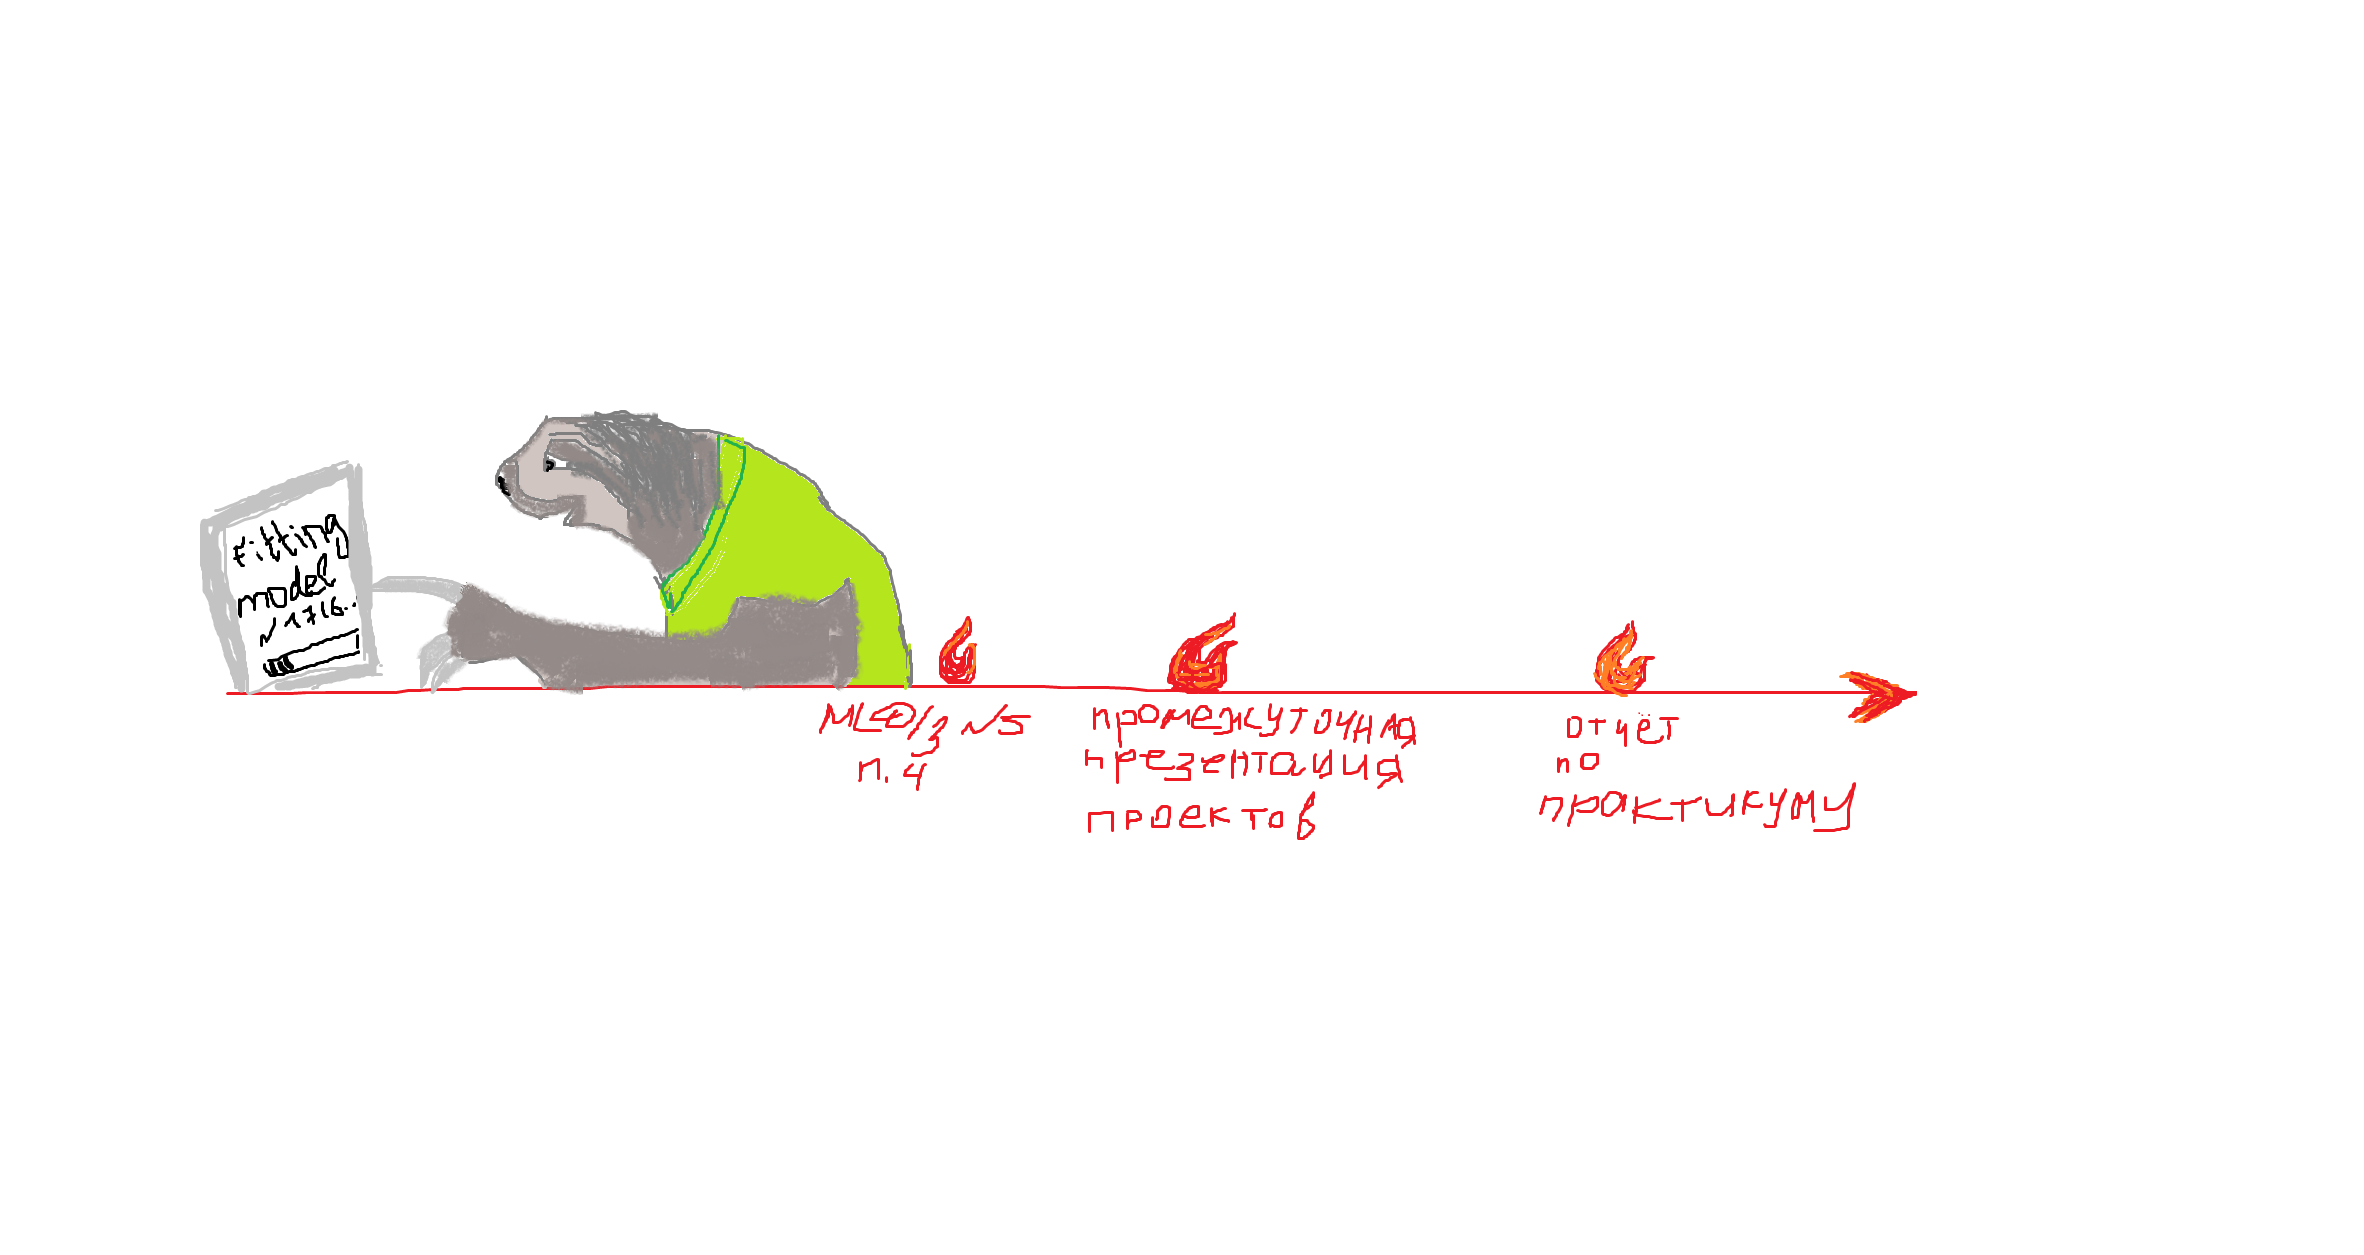

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Расстроилась, что в третьем задании не получилось подобрать модели с высоким скором, хотя вроде рассмотрела все комбинации ( Почему?.. (